In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import time
import sys
from docx import Document
from docx.shared import Inches
class Interpolation:
    def __init__(self,x,y,model):
        if len(x)!=len(y):
            raise ValueError("Warning! length x is not eqal to length y")
        else:
            self.X=x
            self.y=y
            self.model=int(model)
    def Polynomial(self):#多项式插值
        n=len(self.X)
        X=np.array(self.X)
        X=np.vander(X,n,increasing=True)#建立范德蒙德行列式
        y=np.array(self.y)
        temp= lambda x:0
        y=y.T
        a=np.linalg.inv(X.T@X)@X.T@y#求解系数矩阵
        a=list(a)
        global count
        count=n
        def fun(t):
            global count
            count=count-1
            if count>=0:
                return a[count]*t**count+fun(t)#使用递归作为求解函数
            else:
                count=n
                return 0
                
        return fun
    def Neville(self):#内维尔插值
        n=len(self.X)
        x=self.X
        array=np.zeros((n,n))#生成n行n列矩阵用以存储数据进行计算
        for i in range(0,n):
            array[0][i]=self.y[i]#第一行设置初始值
        def fun(t):
            for i in range(1,n):
                for j in range(0,n-i):
                    array[i][j]=1/(x[j]-x[j+i])*((t-x[j+i])*array[i-1][j]-(t-x[j])*array[i-1][j+1])#从左到右，从上到下一层一层计算
            return array[n-1][0]
        return fun
    def Rational(self):#有理函数插值
        n=len(self.X)
        x=self.X
        array=np.zeros((n,n))#生成n行n列矩阵用以存储数据进行计算
        for i in range(0,n):
            array[0][i]=self.y[i]#第一行设置初始值
        def fun(t):#python中-1代表最后一列（行），没必要单独新加入一个维度
            for i in range(1,n):
                for j in range(0,n-i):
                    array[i][j]=array[i-1][j+1]+(array[i-1][j+1]-array[i-1][j])/(((t-x[j])/(t-x[i+j]))*(1-(array[i-1][j+1]-array[i-1][j])/(array[i-1][j+1]-array[i-2][j+1]))-1)
            return array[n-1][0]
        return fun
    def solve(self):
        if self.model==0:
            return self.Polynomial()
        elif self.model==1:
            return self.Neville()
        elif self.model==2:
            return self.Rational()
        

In [2]:
document = Document()
document.add_heading("插值法小结",level=2)
document.add_paragraph('模型0为多项式插值，模型1为内维尔插值，模型2为有理函数插值')
document.add_heading("编程和学习过程中的小结",level=2)
document.add_heading("多项式插值",level=3)
document.add_paragraph('多项式插值的关键在于解出系数矩阵，以及迭代出计算式子')
document.add_picture('{}.jpg'.format(1), width=Inches(3.5))
document.add_heading("内维尔插值",level=3)
document.add_paragraph('内维尔插值的关键在于建立矩阵进行相关的迭代运算')
document.add_heading("有理函数插值",level=3)
document.add_paragraph('有理函数插值有点坑,但是对于tan（x）类型的函数是真的优秀。但有时候会分母为0，对插值点要求比较多，比如插值的时候y不能有0，就是在任何一步运算中都不能有分母为0的情况')
document.add_paragraph('小经验，python的-1可以代表最后一行（列），刚好在初始化时设定为了0，就不用做多余的增加维度的操作了')
document.add_paragraph('PS:我的有理函数插值虽然在某些时刻会碰到分母为0而不能正确输出，但在部分函数，精度优于官方，详见word最后一点')
document.add_heading("时间效率与基准度测试",level=2)
document.add_heading("EXAMPLE1：tan（x），主要在0.8-1.5之间",level=2)

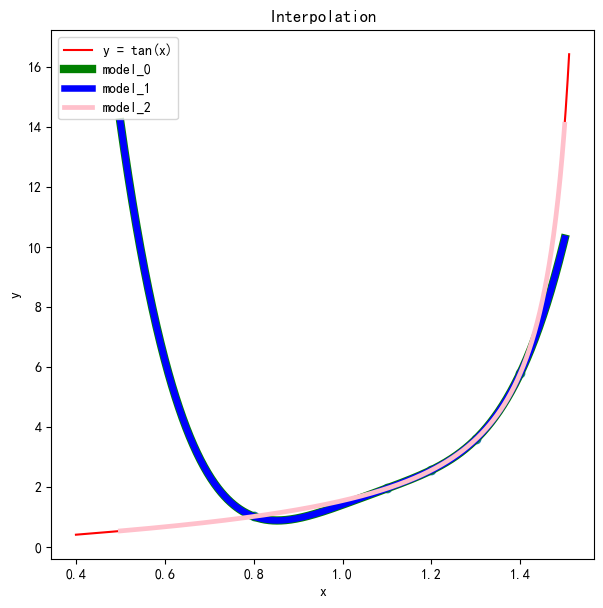

In [3]:
def fun(t):
    y=np.tan(t) 
    return y
fig=plt.figure(figsize=(7,7),dpi=100)
plt.title("Interpolation")
plt.xlabel("x")
plt.ylabel("y")
plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['axes.unicode_minus']=False
x=np.linspace(0.4,1.51,1000)
y=fun(x)
plt.plot(x,y,color='r',label='y = tan(x)')
#五点插值
xchazhi=[0.8,1.1,1.2,1.3,1.4]
ychazhi=[fun(i) for i in xchazhi]
plt.scatter(xchazhi,ychazhi)
for i in range(0,3):
    start_time=time.time()
    locals()['model_'+str(i)]=Interpolation(xchazhi,ychazhi,i)
    locals()['model_fun'+str(i)]=locals()['model_'+str(i)].solve()
    end_time=time.time()
    deltatime=start_time-end_time
    locals()['model_time'+str(i)]=deltatime
x=np.linspace(0.5,1.5,1000)
x=list(x)
yhat=[]
linestyle1=['g','b','pink']
for ii in range(0,3):
    for i in x:
        i=float(i)
        temp=(locals()['model_fun'+str(ii)])(i)
        yhat.append(temp)
    plt.plot(x,yhat,linestyle1[ii],linewidth=(6-ii*1.3),label='model_{}'.format(ii))
    yhat=[]    
plt.legend(loc="upper left")
plt.savefig('./{}.jpg'.format(2))
plt.show()
document.add_picture('{}.jpg'.format(2), width=Inches(3.5))

In [4]:
testinput=[0.75,0.95,1.15,1.35,1.55]
ytrue=[fun(i) for i in testinput]
for ii in range(0,3):
    (locals()['ysave'+str(ii)])=[]
    for i in testinput:
        i=float(i)
        temp=(locals()['model_fun'+str(ii)])(i)
        (locals()['ysave'+str(ii)]).append(temp)
document.add_paragraph('三种模型与精准值比较')
table1= document.add_table(rows=7, cols=7, style='Table Grid')
hc = table1.rows[0].cells
hc[0].text = 'Input'
hc[1].text = 'Value'
hc[2].text = 'Test Input'
hc[3].text = 'True Value'
hc[4].text = 'Polynomial'
hc[5].text = 'Neville'
hc[6].text = 'Rational'
for i in range(1,6):
    bc1 =table1.rows[i].cells
    bc1[0].text=str(xchazhi[i-1])
    bc1[1].text=str(ychazhi[i-1])
    bc1[2].text=str(testinput[i-1])
    bc1[3].text=str(ytrue[i-1])
    bc1[4].text=str(ysave0[i-1])
    bc1[5].text=str(ysave1[i-1])
    bc1[6].text=str(ysave2[i-1])
bc1 =table1.rows[6].cells
bc1[0].text='time'
bc1[4].text=str(model_time0)
bc1[5].text=str(model_time1)
bc1[6].text=str(model_time2)
document.add_paragraph('额，都挺快的，难以比较啊')
document.add_paragraph('             ')
document.add_paragraph('误差值')
table2= document.add_table(rows=6, cols=7, style='Table Grid')
hc = table2.rows[0].cells
hc[0].text = 'Input'
hc[1].text = 'Value'
hc[2].text = 'Test Input'
hc[3].text = 'True Value'
hc[4].text = 'Polynomial'
hc[5].text = 'Neville'
hc[6].text = 'Rational'
for i in range(1,6):
    bc1 =table2.rows[i].cells
    bc1[0].text=str(xchazhi[i-1])
    bc1[1].text=str(ychazhi[i-1])
    bc1[2].text=str(testinput[i-1])
    bc1[3].text=str(ytrue[i-1])
    bc1[4].text=str(ysave0[i-1]-ytrue[i-1])
    bc1[5].text=str(ysave1[i-1]-ytrue[i-1])
    bc1[6].text=str(ysave2[i-1]-ytrue[i-1])
bc1 =table1.rows[6].cells
document.add_paragraph('可以看到，外推精度有明显下降，对于突变型函数，有理函数插值会比较好')

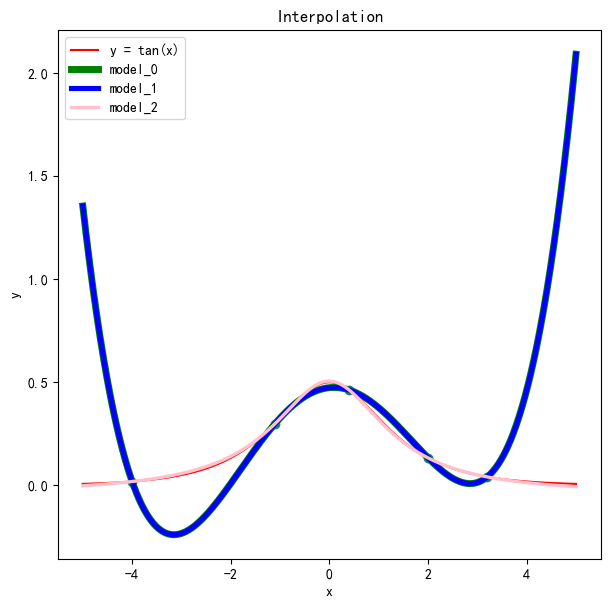

In [5]:
document.add_page_break()
document.add_heading('Example 2 y=1/(np.exp(-x)+np.exp(x))',level=2)
def fun(t):
    y=1/(np.exp(-t)+np.exp(t))
    return y
fig=plt.figure(figsize=(7,7),dpi=100)
plt.title("Interpolation")
plt.xlabel("x")
plt.ylabel("y")
plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['axes.unicode_minus']=False
x=np.linspace(-5,5,1000)
y=fun(x)
plt.plot(x,y,color='r',label='y = tan(x)')
#五点插值
xchazhi=[-4,-1.1,0.4,2,3.2]
ychazhi=[fun(i) for i in xchazhi]
plt.scatter(xchazhi,ychazhi)
for i in range(0,3):
    start_time=time.time()
    locals()['model_'+str(i)]=Interpolation(xchazhi,ychazhi,i)
    locals()['model_fun'+str(i)]=locals()['model_'+str(i)].solve()
    end_time=time.time()
    deltatime=start_time-end_time
    locals()['model_time'+str(i)]=deltatime
x=np.linspace(-5,5,1000)
x=list(x)
yhat=[]
linestyle1=['g','b','pink']
for ii in range(0,3):
    for i in x:
        i=float(i)
        temp=(locals()['model_fun'+str(ii)])(i)
        yhat.append(temp)
    plt.plot(x,yhat,linestyle1[ii],linewidth=(5-ii*1.3),label='model_{}'.format(ii))
    yhat=[]    
plt.legend(loc="upper left")
plt.savefig('./{}.jpg'.format(3))
plt.show()
document.add_picture('{}.jpg'.format(3), width=Inches(3.5))


In [6]:
testinput=[-4.5,-1.6,0,2.7,3.8]
ytrue=[fun(i) for i in testinput]
for ii in range(0,3):
    (locals()['ysave'+str(ii)])=[]
    for i in testinput:
        i=float(i)
        temp=(locals()['model_fun'+str(ii)])(i)
        (locals()['ysave'+str(ii)]).append(temp)
document.add_paragraph('三种模型与精准值比较')
table1= document.add_table(rows=7, cols=7, style='Table Grid')
hc = table1.rows[0].cells
hc[0].text = 'Input'
hc[1].text = 'Value'
hc[2].text = 'Test Input'
hc[3].text = 'True Value'
hc[4].text = 'Polynomial'
hc[5].text = 'Neville'
hc[6].text = 'Rational'
for i in range(1,6):
    bc1 =table1.rows[i].cells
    bc1[0].text=str(xchazhi[i-1])
    bc1[1].text=str(ychazhi[i-1])
    bc1[2].text=str(testinput[i-1])
    bc1[3].text=str(ytrue[i-1])
    bc1[4].text=str(ysave0[i-1])
    bc1[5].text=str(ysave1[i-1])
    bc1[6].text=str(ysave2[i-1])
bc1 =table1.rows[6].cells
bc1[0].text='time'
bc1[4].text=str(model_time0)
bc1[5].text=str(model_time1)
bc1[6].text=str(model_time2)
document.add_paragraph('额，都挺快的，难以比较啊')
document.add_paragraph('             ')
document.add_paragraph('误差值')
table2= document.add_table(rows=6, cols=7, style='Table Grid')
hc = table2.rows[0].cells
hc[0].text = 'Input'
hc[1].text = 'Value'
hc[2].text = 'Test Input'
hc[3].text = 'True Value'
hc[4].text = 'Polynomial'
hc[5].text = 'Neville'
hc[6].text = 'Rational'
for i in range(1,6):
    bc1 =table2.rows[i].cells
    bc1[0].text=str(xchazhi[i-1])
    bc1[1].text=str(ychazhi[i-1])
    bc1[2].text=str(testinput[i-1])
    bc1[3].text=str(ytrue[i-1])
    bc1[4].text=str(ysave0[i-1]-ytrue[i-1])
    bc1[5].text=str(ysave1[i-1]-ytrue[i-1])
    bc1[6].text=str(ysave2[i-1]-ytrue[i-1])
bc1 =table1.rows[6].cells
document.add_paragraph('可以看到，外推精度有明显下降，显然对于需要外推的炒股，插值方法不太实用')

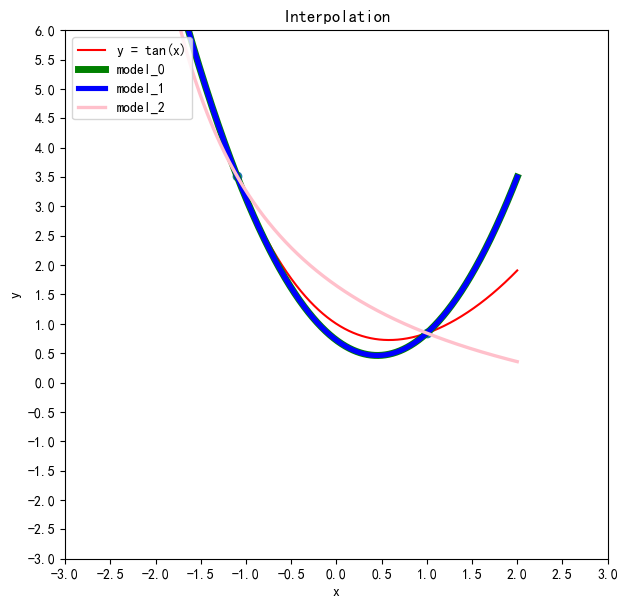

In [7]:
document.add_page_break()
document.add_heading('Example 3 y=（x-1)^2+sin(x)',level=2)
def fun(t):
    y=(t-1)**2+np.sin(t)
    return y
fig=plt.figure(figsize=(7,7),dpi=100)
plt.title("Interpolation")
plt.xlabel("x")
plt.ylabel("y")
plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['axes.unicode_minus']=False
x_major_locator=MultipleLocator(0.5)
y_major_locator=MultipleLocator(0.5)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlim(-3,3)
plt.ylim(-3,6)
x=np.linspace(-2,2,1000)
y=fun(x)
plt.plot(x,y,color='r',label='y = tan(x)')
#五点插值
xchazhi=[-2,-1.1,1]
ychazhi=[fun(i) for i in xchazhi]
plt.scatter(xchazhi,ychazhi)
for i in range(0,3):
    start_time=time.time()
    locals()['model_'+str(i)]=Interpolation(xchazhi,ychazhi,i)
    locals()['model_fun'+str(i)]=locals()['model_'+str(i)].solve()
    end_time=time.time()
    deltatime=start_time-end_time
    locals()['model_time'+str(i)]=deltatime
x=np.linspace(-2,2,1000)
x=list(x)
yhat=[]
linestyle1=['g','b','pink']
for ii in range(0,3):
    for i in x:
        i=float(i)
        temp=(locals()['model_fun'+str(ii)])(i)
        yhat.append(temp)
    plt.plot(x,yhat,linestyle1[ii],linewidth=(5-ii*1.3),label='model_{}'.format(ii))
    yhat=[]    
plt.legend(loc="upper left")
plt.savefig('./{}.jpg'.format(4))
plt.show()
document.add_picture('{}.jpg'.format(4), width=Inches(3.5))


In [8]:
testinput=[-3,-1.2,1.8]
ytrue=[fun(i) for i in testinput]
for ii in range(0,3):
    (locals()['ysave'+str(ii)])=[]
    for i in testinput:
        i=float(i)
        temp=(locals()['model_fun'+str(ii)])(i)
        (locals()['ysave'+str(ii)]).append(temp)
document.add_paragraph('三种模型与精准值比较')
table1= document.add_table(rows=5, cols=7, style='Table Grid')
hc = table1.rows[0].cells
hc[0].text = 'Input'
hc[1].text = 'Value'
hc[2].text = 'Test Input'
hc[3].text = 'True Value'
hc[4].text = 'Polynomial'
hc[5].text = 'Neville'
hc[6].text = 'Rational'
for i in range(1,4):
    bc1 =table1.rows[i].cells
    bc1[0].text=str(xchazhi[i-1])
    bc1[1].text=str(ychazhi[i-1])
    bc1[2].text=str(testinput[i-1])
    bc1[3].text=str(ytrue[i-1])
    bc1[4].text=str(ysave0[i-1])
    bc1[5].text=str(ysave1[i-1])
    bc1[6].text=str(ysave2[i-1])
bc1 =table1.rows[4].cells
bc1[0].text='time'
bc1[4].text=str(model_time0)
bc1[5].text=str(model_time1)
bc1[6].text=str(model_time2)
document.add_paragraph('额，都挺快的，难以比较啊')
document.add_paragraph('             ')
document.add_paragraph('误差值')
table2= document.add_table(rows=6, cols=7, style='Table Grid')
hc = table2.rows[0].cells
hc[0].text = 'Input'
hc[1].text = 'Value'
hc[2].text = 'Test Input'
hc[3].text = 'True Value'
hc[4].text = 'Polynomial'
hc[5].text = 'Neville'
hc[6].text = 'Rational'
for i in range(1,4):
    bc1 =table2.rows[i].cells
    bc1[0].text=str(xchazhi[i-1])
    bc1[1].text=str(ychazhi[i-1])
    bc1[2].text=str(testinput[i-1])
    bc1[3].text=str(ytrue[i-1])
    bc1[4].text=str(ysave0[i-1]-ytrue[i-1])
    bc1[5].text=str(ysave1[i-1]-ytrue[i-1])
    bc1[6].text=str(ysave2[i-1]-ytrue[i-1])
bc1 =table1.rows[4].cells
document.add_paragraph('可以看到，外推精度有明显下降,但在这种模型中，多项式模型效果更好')
document.add_page_break()

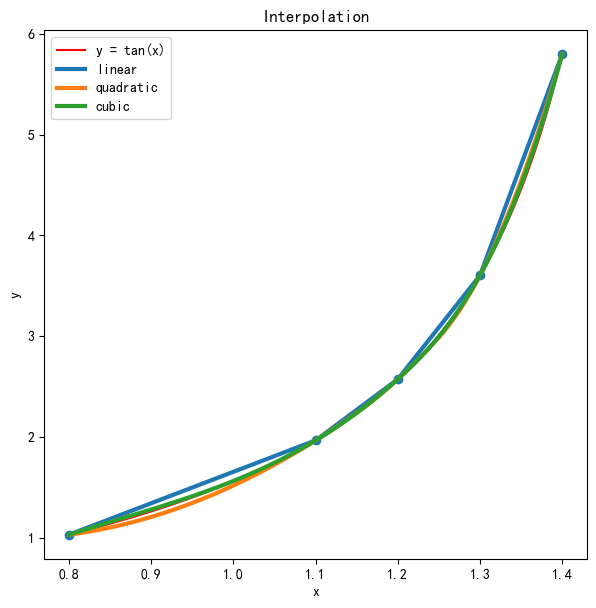

In [9]:
document.add_heading('接下来就是官方库了',level=1)
document.add_paragraph('PYTHON 库主要是scipy.interpolate，对于这种分段插值，只支持内插，但由于分段的原因，精度还是蛮高的')
from scipy import interpolate as itp
def fun(t):
    y=np.tan(t) 
    return y
fig=plt.figure(figsize=(7,7),dpi=100)
plt.title("Interpolation")
plt.xlabel("x")
plt.ylabel("y")
plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['axes.unicode_minus']=False
x=np.linspace(0.8,1.4,1000)
y=fun(x)
plt.plot(x,y,color='r',label='y = tan(x)')
#五点分段插值
xchazhi=[0.8,1.1,1.2,1.3,1.4]
ychazhi=[fun(i) for i in xchazhi]
plt.scatter(xchazhi,ychazhi)
ls = ["linear", "quadratic", "cubic"]
sample=1000
x0 = np.linspace(0.8, 1.4, sample)
for i in range(len(ls)):
    f = itp.interp1d(xchazhi, ychazhi, kind=ls[i])
    y0 = f(x0)
    plt.plot(x0, y0, linewidth=3, label=ls[i])
plt.legend(loc="upper left")
plt.savefig('./{}.jpg'.format(5))
plt.show()
document.add_picture('{}.jpg'.format(5), width=Inches(3.5))


In [10]:
testinput=[0.83,0.95,1.15,1.21,1.38]
ytrue=[fun(i) for i in testinput]

for ii in range(0,3):
    (locals()['ysave'+str(ii)])=[]
for i in range(len(ls)):
    f = itp.interp1d(xchazhi, ychazhi, kind=ls[i])
    y0 = f(testinput)
    (locals()['ysave'+str(i)])=(list(y0))
print(ysave0)
document.add_paragraph('三种模型与精准值比较')
table1= document.add_table(rows=6, cols=7, style='Table Grid')
hc = table1.rows[0].cells
hc[0].text = 'Input'
hc[1].text = 'Value'
hc[2].text = 'Test Input'
hc[3].text = 'True Value'
hc[4].text = 'Linear'
hc[5].text = 'Quadratic'
hc[6].text = 'Cubic'
for i in range(1,6):
    bc1 =table1.rows[i].cells
    bc1[0].text=str(xchazhi[i-1])
    bc1[1].text=str(ychazhi[i-1])
    bc1[2].text=str(testinput[i-1])
    bc1[3].text=str(ytrue[i-1])
    bc1[4].text=str(ysave0[i-1])
    bc1[5].text=str(ysave1[i-1])
    bc1[6].text=str(ysave2[i-1])
document.add_paragraph('             ')
document.add_paragraph('误差值')
table2= document.add_table(rows=6, cols=7, style='Table Grid')
hc = table2.rows[0].cells
hc[0].text = 'Input'
hc[1].text = 'Value'
hc[2].text = 'Test Input'
hc[3].text = 'True Value'
hc[4].text = 'Polynomial'
hc[5].text = 'Neville'
hc[6].text = 'Rational'
for i in range(1,6):
    bc1 =table2.rows[i].cells
    bc1[0].text=str(xchazhi[i-1])
    bc1[1].text=str(ychazhi[i-1])
    bc1[2].text=str(testinput[i-1])
    bc1[3].text=str(ytrue[i-1])
    bc1[4].text=str(ysave0[i-1]-ytrue[i-1])
    bc1[5].text=str(ysave1[i-1]-ytrue[i-1])
    bc1[6].text=str(ysave2[i-1]-ytrue[i-1])
document.add_paragraph('可以看到，通过分段插值，大大提高了整体插值的精度')
document.add_page_break()

[1.1231506670701927, 1.4971991071495079, 2.2684556396874846, 2.675146704710485, 5.358727461979904]


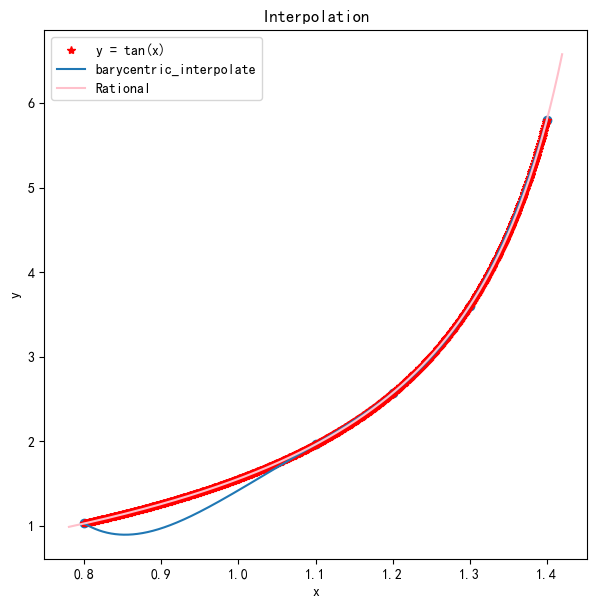

In [11]:
document.add_paragraph('当然，python官方库也可以进行有理函数插值')
from scipy import interpolate as itp
def fun(t):
    y=np.tan(t) 
    return y
fig=plt.figure(figsize=(7,7),dpi=100)
plt.title("Interpolation")
plt.xlabel("x")
plt.ylabel("y")
plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['axes.unicode_minus']=False
x=np.linspace(0.8,1.4,1000)
y=fun(x)
plt.plot(x,y,'r*',label='y = tan(x)')
#五点分段插值
xchazhi=[0.8,1.1,1.2,1.3,1.4]
ychazhi=[fun(i) for i in xchazhi]
plt.scatter(xchazhi,ychazhi)
yhat=itp.barycentric_interpolate(xchazhi, ychazhi, x, axis=0)
plt.plot(x,yhat,label='barycentric_interpolate')
#五点插值
locals()['model_'+str(2)]=Interpolation(xchazhi,ychazhi,2)
locals()['model_fun'+str(2)]=locals()['model_'+str(2)].solve()
x=np.linspace(0.78,1.42,1000)
x=list(x)
yhat=[]
linestyle1=['pink']
for i in x:
    i=float(i)
    temp=(locals()['model_fun'+str(2)])(i)
    yhat.append(temp)
plt.plot(x,yhat,linestyle1[0],linewidth=1.5,label='Rational')
yhat=[]    
plt.legend(loc="upper left")
plt.savefig('./{}.jpg'.format(6))
plt.show()
document.add_picture('{}.jpg'.format(6), width=Inches(3.5))
document.add_paragraph("至少可以看到，在这段区间内，我编写的插值比官方好！")
document.add_paragraph("至少可以看到，在这段区间内，我编写的插值比官方好！")
document.add_paragraph("至少可以看到，在这段区间内，我编写的插值比官方好！")

In [12]:
testinput=[0.83,0.95,1.15,1.21,1.38]
ytrue=[fun(i) for i in testinput]
yhat1=itp.barycentric_interpolate(xchazhi, ychazhi, testinput, axis=0)
ysave0=list(yhat1)
ysave1=[]
for i in testinput:
    temp=model_fun2(i)
    ysave1.append(temp)
document.add_paragraph('三种模型与精准值比较')
table1= document.add_table(rows=6, cols=6, style='Table Grid')
hc = table1.rows[0].cells
hc[0].text = 'Input'
hc[1].text = 'Value'
hc[2].text = 'Test Input'
hc[3].text = 'True Value'
hc[4].text = 'Neville'
hc[5].text = 'Rational'
for i in range(1,5):
    bc1 =table1.rows[i].cells
    bc1[0].text=str(xchazhi[i-1])
    bc1[1].text=str(ychazhi[i-1])
    bc1[2].text=str(testinput[i-1])
    bc1[3].text=str(ytrue[i-1])
    bc1[4].text=str(ysave0[i-1])
    bc1[5].text=str(ysave1[i-1])
document.add_paragraph('             ')
document.add_paragraph('误差值')
table2= document.add_table(rows=6, cols=6, style='Table Grid')
hc = table2.rows[0].cells
hc[0].text = 'Input'
hc[1].text = 'Value'
hc[2].text = 'Test Input'
hc[3].text = 'True Value'
hc[4].text = 'Neville'
hc[5].text = 'Rational'
for i in range(1,5):
    bc1 =table2.rows[i].cells
    bc1[0].text=str(xchazhi[i-1])
    bc1[1].text=str(ychazhi[i-1])
    bc1[2].text=str(testinput[i-1])
    bc1[3].text=str(ytrue[i-1])
    bc1[4].text=str(ysave0[i-1]-ytrue[i-1])
    bc1[5].text=str(ysave1[i-1]-ytrue[i-1])
document.add_paragraph('可以看到，就这个函数来说，我的精度更高')
document.add_page_break()

In [13]:
document.add_heading('接下来关于C++库',level=1)
document.add_paragraph("闭着眼睛都知道，C++的编译速度高于python的，但对于这种速度已经非常快的插值方法来说，这点小小的差异简直可以忽略不计")
document.add_paragraph("C++ 使用 boost 库实现插值算法,但不能直接用")
document.add_paragraph("按照官方文档给出的示例教程，在main函数中添加相应的插值函数的头文件，如：")
document.add_paragraph("#include <boost/math/interpolators/pchip.hpp>")
document.add_paragraph("修改一系列项目")
document.add_paragraph("拥有许多种插值函数")
document.add_paragraph("Cardinal Cubic B-spline interpolation 在等间距点采样的函数提供精准快速的插值方法")
document.add_paragraph("Barycentric Rational Interpolation 为采样点非均匀分布的数据提供插值方法")
document.add_paragraph("Modified Akima interpolation 采用cubic Hermite polynomials方法对非等间隔采样的数据进行插值，多项式斜率由 Akima 提出的修正后的几何重构法确定")
document.add_paragraph("PCHIP interpolation 与Modified Akima interpolation类似，PCHIP interpolation也采用cubic Hermite polynomials方法对非等间隔采样的数据进行插值，但斜率由另一种方法确定。")

In [14]:
document.save('1.docx')

# 编程笔记
有理函数插值有点坑,但是对于tan（x）类型的函数是真的优秀

有时候会分母为0，要求比较多

比如插值的时候y不能有0，就是在任何一步运算中都不能有分母为0的情况

经验，python的-1可以代表最后一行（列），刚好在初始化时设定为了0，就不用做多余的增加维度的操作了

